In [1]:
import pandas as pd
import numpy as np
import json
import sys
import re

In [2]:
from src import *

business_df = pd.read_json('../database/yelp_academic_dataset_business.json', lines=True)
review_df = pd.read_json('../database/yelp_academic_dataset_review.json', lines=True)
pred_df = pd.read_json('../database/review_predictions.json', lines=True)

In [3]:
# Set the lambda value
_lambda = 0.3  # Can be adjusted as needed

review_df = review_df.merge(pred_df, on='review_id', how='left')

In [4]:
# Merge review_df and pred_df just for checking
check_df = review_df[['review_id', 'stars']].merge(pred_df[['review_id', 'true_stars']], on='review_id', how='inner')

# Check whether the two columns are identical
mismatch = (check_df['stars'] != check_df['true_stars']).sum()

if mismatch > 0:
    print(f"Warning: There are {mismatch} records where 'stars' and 'true_stars' do not match!")
else:
    print("Check passed: All 'stars' and 'true_stars' are identical.")

Check passed: All 'stars' and 'true_stars' are identical.


In [5]:
review_df['stars'] = (_lambda * review_df['predicted_stars'] + (1 - _lambda) * review_df['true_stars']).round(2)
review_df.drop(['predicted_stars'], axis=1, inplace=True)

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
main_color = ['#00754B', '#C8FCEA', '#6A9A8B']

# Exploratory Data Analysis

## View the number of unique business categories in each city

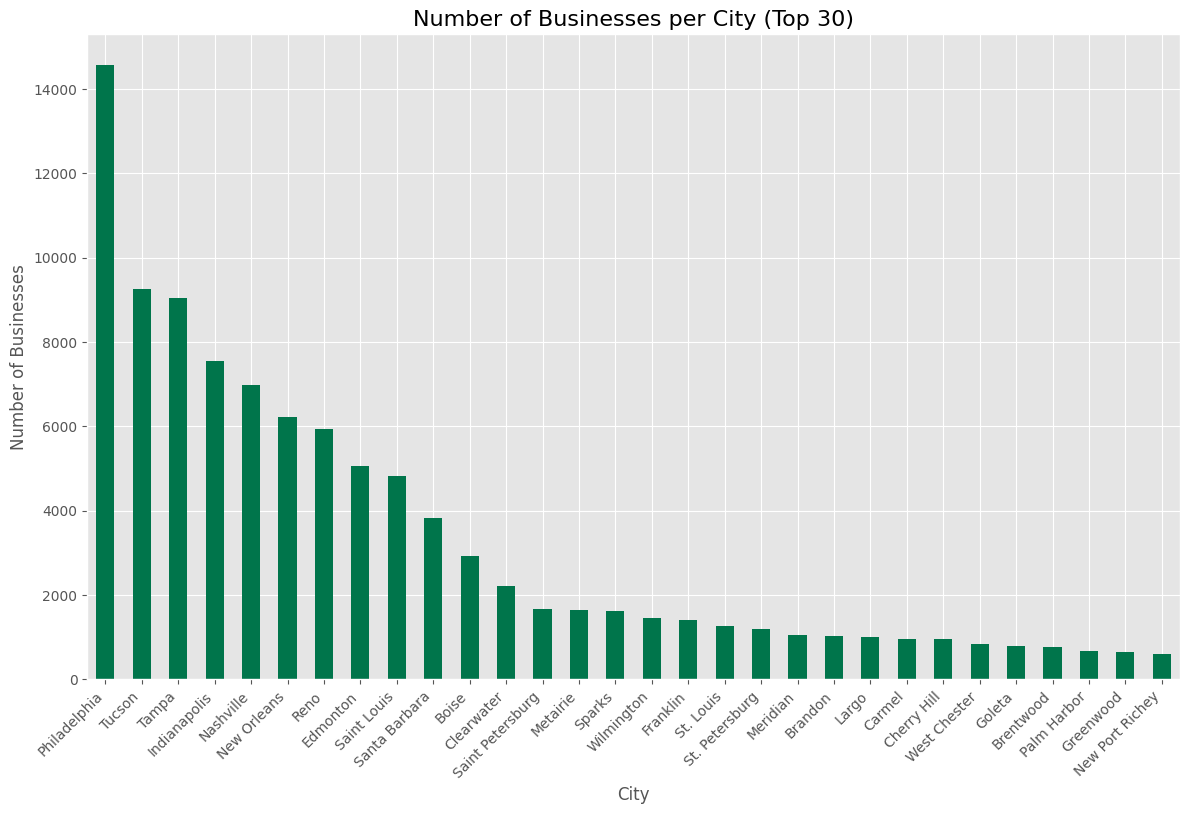

In [7]:
# Group by city and count the number of businesses
yelp_business_groups = business_df.groupby('city').count()
yelp_business_city = yelp_business_groups['name']
yelp_business_city_sorted = yelp_business_city.sort_values(ascending=False)

# Plot a bar chart for the top 30 cities
ax = yelp_business_city_sorted[:30].plot(kind='bar', figsize=(12, 8), color=main_color[0])
ax.set_xticklabels(yelp_business_city_sorted[:30].index, rotation=45, ha='right')

ax.set_xlabel('City')
ax.set_ylabel('Number of Businesses')
plt.tight_layout()
plt.savefig('../static/experiments/01_Number_of_Businesses_per_City.png', dpi=600)
ax.set_title('Number of Businesses per City (Top 30)', fontsize=16)

plt.show()

## View the different types of business categories and their respective counts

In [8]:
categories_dict = {}
for _ in business_df.categories:
    cat = str(_).split(',')
    for j in cat:
        # Standardize category names
        j = j.strip().lower()
        if j not in categories_dict:
            categories_dict[j] = 1
        else:
            categories_dict[j] += 1

categories_series = pd.Series(categories_dict)
categories_series.sort_values(ascending=False, inplace=True)

print("Top 30 Business Categories and their Counts:")
print(categories_series[:30])

Top 30 Business Categories and their Counts:
restaurants                  52268
food                         27781
shopping                     24395
home services                14356
beauty & spas                14292
nightlife                    12281
health & medical             11890
local services               11198
bars                         11065
automotive                   10773
event planning & services     9895
sandwiches                    8366
american (traditional)        8139
active life                   7687
pizza                         7093
coffee & tea                  6703
fast food                     6472
breakfast & brunch            6239
american (new)                6097
hotels & travel               5857
home & garden                 5799
fashion                       5739
burgers                       5636
arts & entertainment          5434
auto repair                   5433
hair salons                   5046
nail salons                   4621
mexican   

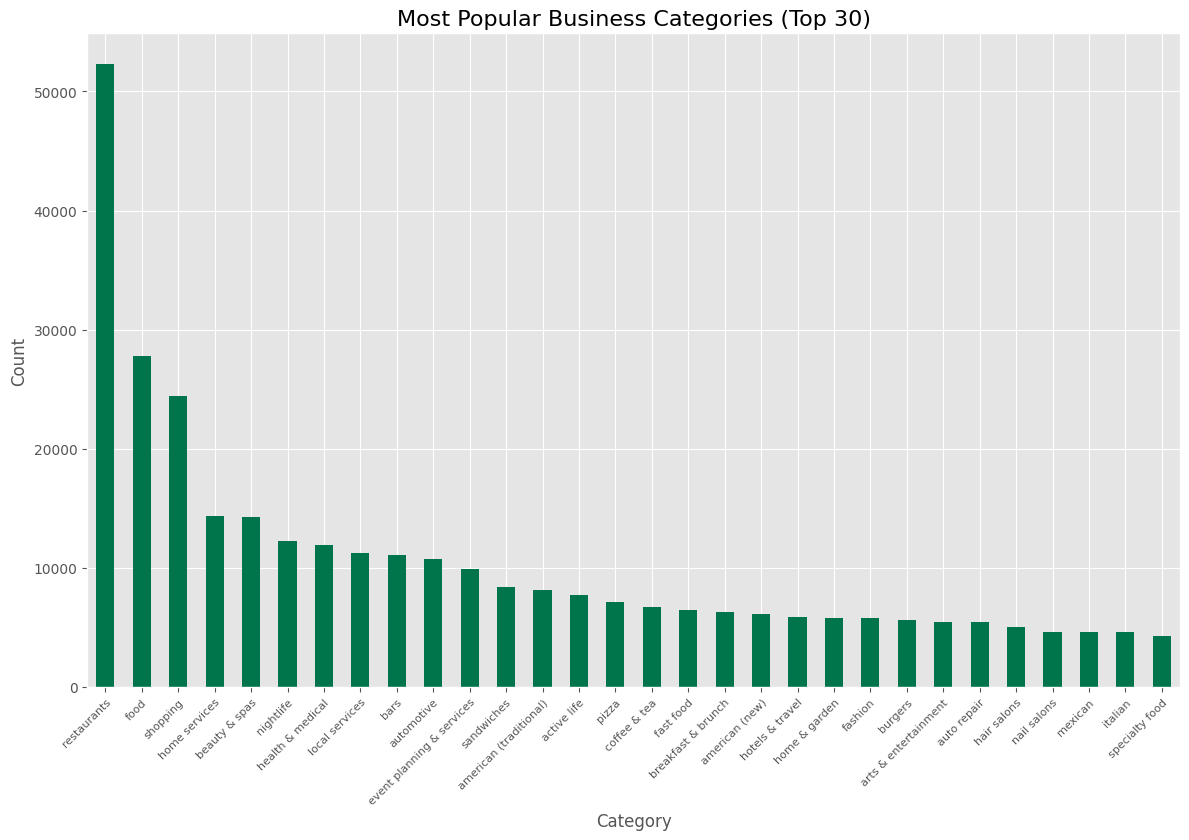

In [9]:
# Plot a bar chart of the top 30 most popular business categories
ax = categories_series[:30].plot(
    kind='bar', color=main_color[0], figsize=(12, 8))
ax.set_xticklabels(
    categories_series[:30].index,
    rotation=45, ha='right', wrap=True,
    fontsize=8)

ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig('../static/experiments/02_Most_Popular_Business_Categories.png', dpi=600)
ax.set_title('Most Popular Business Categories (Top 30)', fontsize=16)

plt.show()

We reclassify according to six major categories: Shops, Hotels, Restaurants, Bars, Fitness, Events.

In [10]:
CATEGORY_KEYWORDS = {
    "Shops": ["shop"],
    "Hotels": ["hotel"],
    "Restaurants": ["restaurant", r"\w+an$", r"\w+ese$", r"\w+ish$", r"\w+ch$", r"\w+ic$", "food"],
    "Bars": ["bar"],
    "Fitness": ["fitness", "gym", "exercise"],
    "Events": ["event"]
}

category_count = {category: 0 for category in CATEGORY_KEYWORDS.keys()}
category_count["Others"] = 0

unique_business_ids = set()

# A dictionary to store unmatched business_id and their categories
others = {}

# Loop through the business categories and categorize them
for _, row in business_df.iterrows():
    business_id = row['business_id']
    if business_id not in unique_business_ids:
        unique_business_ids.add(business_id)
        
        cat = str(row['categories']).split(',')
        matched = False
        
        for j in cat:
            j = j.strip().lower()
            
            for major_category, keywords in CATEGORY_KEYWORDS.items():
                if any(keyword in j for keyword in keywords):
                    category_count[major_category] += 1
                    matched = True
                    break
        if not matched:
            category_count["Others"] += 1
            others[business_id] = row['categories']

category_count_series = pd.Series(category_count)

print("Major Categories and their Counts:")
print(category_count_series)

Major Categories and their Counts:
Shops           31634
Hotels           8836
Restaurants    100057
Bars            25538
Fitness          5557
Events          13837
Others          49729
dtype: int64


## Ordered pairs of business categories and cities with their counts

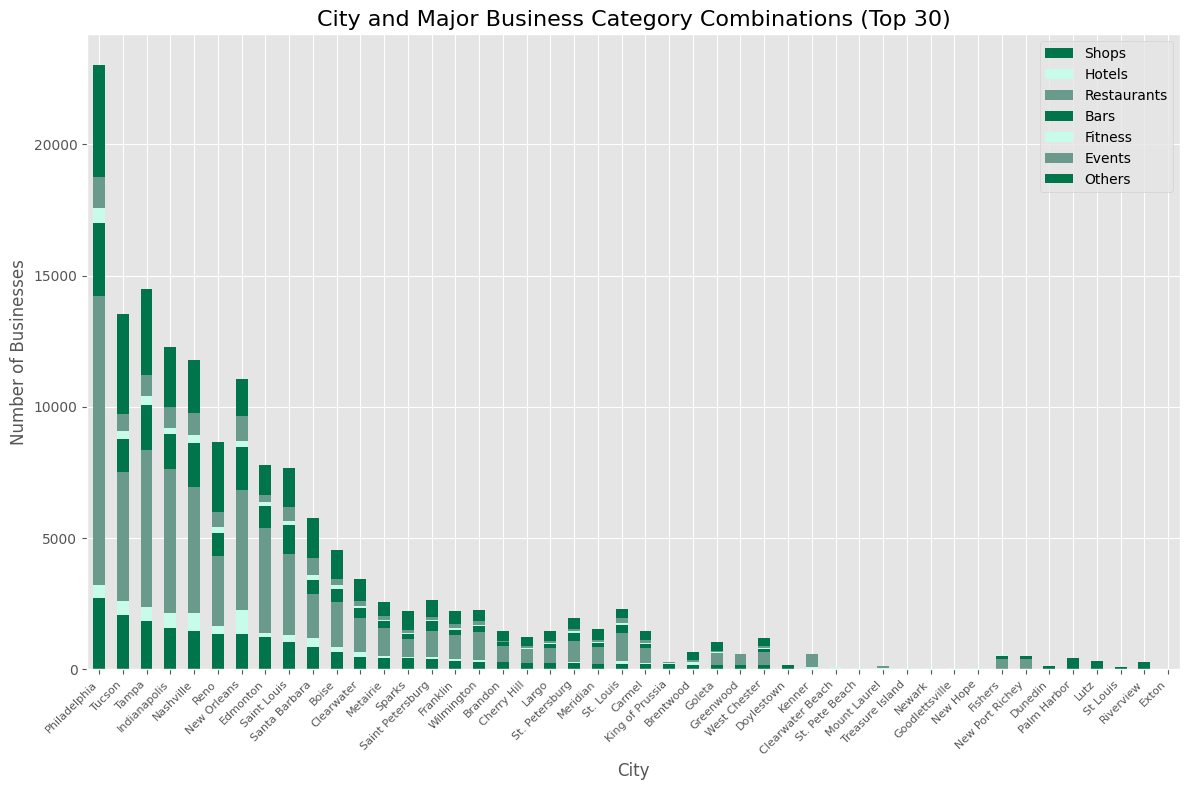

In [11]:
# Create the city-category dictionary to store the number of businesses per city-category pair
city_category_count = {category: {} for category in CATEGORY_KEYWORDS.keys()}
city_category_count["Others"] = {}

# Loop through the business categories and categorize them based on city and major category
for _, row in business_df.iterrows():
    business_id = row['business_id']
    city = row['city'].strip()
    
    # Process the categories of the business
    cat = str(row['categories']).split(',')
    matched = False
    
    for category in cat:
        category = category.strip().lower()
        
        # Match category to major categories
        for major_category, keywords in CATEGORY_KEYWORDS.items():
            if any(keyword in category for keyword in keywords):
                # Increment city-category pair count
                if city not in city_category_count[major_category]:
                    city_category_count[major_category][city] = 1
                else:
                    city_category_count[major_category][city] += 1
                matched = True
                break
        
    # If no match was found, assign to "Others"
    if not matched:
        if city not in city_category_count["Others"]:
            city_category_count["Others"][city] = 1
        else:
            city_category_count["Others"][city] += 1

# Convert the dictionary to a Series and sort it for plotting
city_category_series = {}
for category, cities in city_category_count.items():
    city_category_series[category] = pd.Series(cities).sort_values(ascending=False)

# Plot the top 30 city-category combinations
fig, ax = plt.subplots(figsize=(12, 8))

# Combine the city-category counts of the top categories to be visualized
top_cities = pd.concat([city_category_series[category].head(30) for category in CATEGORY_KEYWORDS.keys()] + 
                       [city_category_series["Others"].head(30)], axis=1)

top_cities.columns = list(CATEGORY_KEYWORDS.keys()) + ["Others"]

top_cities.plot(kind='bar', stacked=True, figsize=(12, 8), ax=ax, color=main_color)

# Set labels and title
ax.set_xlabel('City')
ax.set_ylabel('Number of Businesses')
ax.set_title('City and Major Business Category Combinations (Top 30)', fontsize=16)

# Rotate and format x-tick labels
ax.set_xticklabels(top_cities.index, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig('../static/experiments/03_City_Category_Combination_Counts.png', dpi=600)
plt.show()

It is evident that the majority of businesses listed on Yelp are restaurants, shops, and entertainment centers.

For this dataset, the cities with the highest number of businesses are `Philadelphia`, `Tampa`, and `Indianapolis`.

In [12]:
restaurants = business_df[business_df['categories'].apply(lambda x: any(re.search(pattern, str(x).lower()) for pattern in CATEGORY_KEYWORDS["Restaurants"]))]
restaurant_reviews = review_df[review_df.business_id.isin(restaurants['business_id'])]
print(f"Dimensions of restaurant_reviews dataframe: {restaurant_reviews.shape}")

Dimensions of restaurant_reviews dataframe: (5127464, 10)


# Clean review data

## Remove unnecessary columns

- `text`: review text,
- `useful`: number of users who found the review useful,
- `date`: review date

The remaining columns are `user_id`, `business_id`, and `stars`(processed and summed).

In [13]:
restaurant_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5127464 entries, 0 to 6990279
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        float64       
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
 9   true_stars   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 430.3+ MB


In [14]:
yelp_cleaned = restaurant_reviews.drop(['text', 'useful', 'cool', 'date', 'funny'], axis=1)
yelp_cleaned.head()

,review_id,user_id,business_id,stars,true_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,3
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.3,3
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,5
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,4
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1


## Merge data
Merge business data (`yelp_academic_dataset_business.json`) with review data (`yelp_academic_dataset_review.json`) using 'business_id' as the primary key. Information like 'city' and 'categories' from the business file will be added to the corresponding reviews.

In [15]:
yelp_full = yelp_cleaned.merge(business_df[['state', 'city', 'categories', 'business_id']], how='inner', on='business_id')
df = yelp_full.dropna()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5127464 entries, 0 to 5127463
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   true_stars   int64  
 5   city         object 
 6   categories   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 273.8+ MB


Retrieve the top 30 business categories and cities with the highest number of reviews

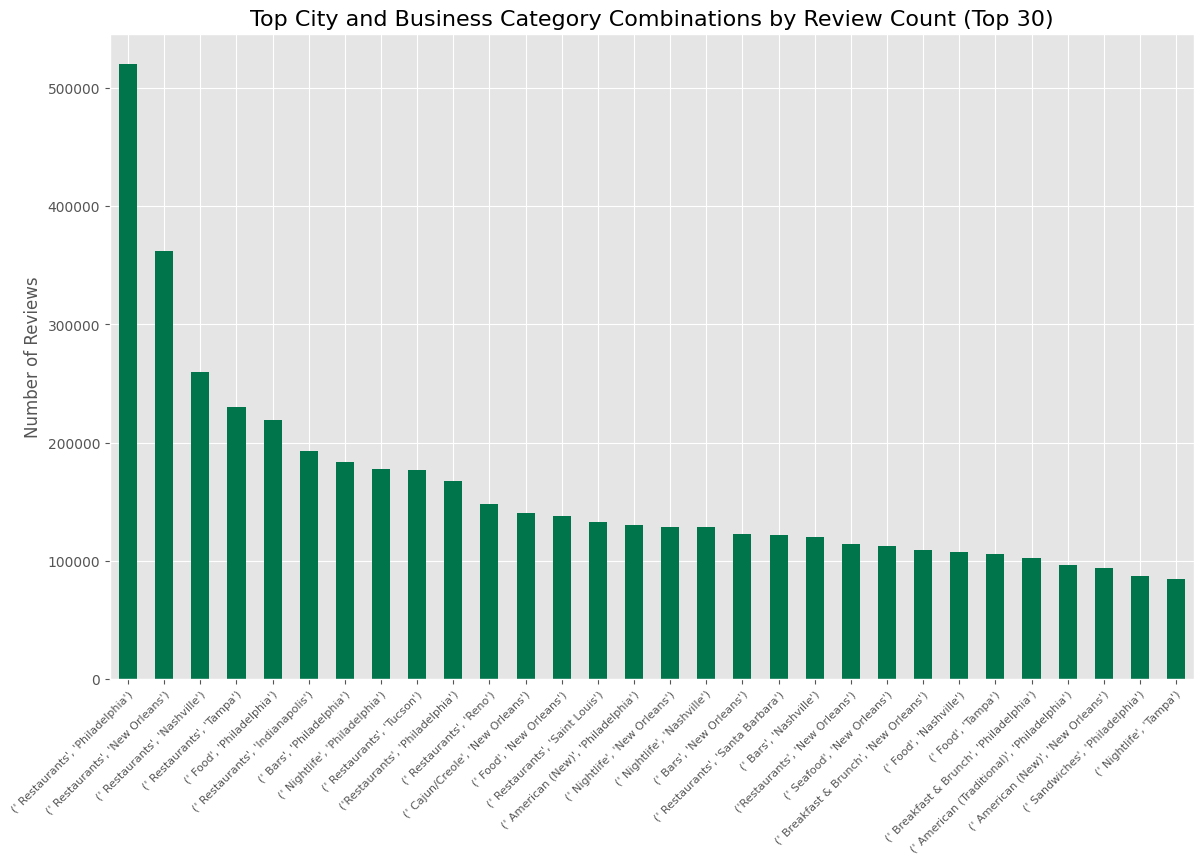

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

review_business_city = get_top_m_num_reviews_for_city_and_business(df, 30)

review_business_city[:30].plot(kind='bar', color=main_color[0], ax=ax)

ax.set_xticklabels(review_business_city[:30].index, rotation=45, ha='right', wrap=True, fontsize=8)
ax.set_xlabel('City - Business Category')
ax.set_ylabel('Number of Reviews')
plt.tight_layout()
plt.savefig('../static/experiments/04_Top_City_Business_Review_Counts.png', dpi=600)
ax.set_title('Top City and Business Category Combinations by Review Count (Top 30)', fontsize=16)

plt.show()

In [18]:
df.to_csv('../database/Yelp_final.csv', index=False)